<a href="https://colab.research.google.com/github/shuseiyokoi/data-science-portfolio/blob/main/SHAP/SHAP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# The theory and implementation of SHAP (SHapley Additive exPlanations)


## Theory

**SHapley Additive exPlanations (SHAP)** is a method to understand how our AI model came to a certain decision. For example, if your task is to make AI for the loan screening process, you need to make sure why your AI came up to the conclusion because your applicant would desperate to know why they failed. The idea of SHAP is to allocate/calculate credits for each explanatory variable on the prediction. For example, in cooperative game theory, a player is able to choose "join" or "not join" the game. And if all players are "join" the game except player A, the difference between the result of the game within all players and the game without player A is going to be credited to player A. SHAP does a similer process to the model to help us to understand the behavior of the model.  

### Additive Feature Attribution Method  
SHAP computes credits by calculating the difference of the overall prediction and an individual prediction. For example, a model $\hat{f}(X)$ with explanatory variable $X = (X_1,...,X_J)$. So explanatory variables for observation $i$ are $x_i=(x_{i,1}...,x_{i,J})$. In SHAP, the credits are break down into the addition form.   


$$
\hat{f}(x_i) - \mathbb{E}\big[\hat{f}(X)\big] =  \sum_{j = 1}^{J} \phi_{i,j}
$$

Breaking down into summation from called **Additive Feature Attribution Method** and SHAP is one of the Additive Feature Attribution Methods. Often, by setting $\phi_0 =  \mathbb{E}\big[\hat{f}(X)\big]$ SHAP is notated as  

$$
\hat{f}(x_i) = \phi_{0} - \sum_{j = 1}^{J} \phi_{i,j}
$$

For example, let's say our goal is to predict annual salary from education, job title, job position, and English skill. The prediction formula would be  

$$
\hat{f}(x_i) = \phi_0 + \phi_i, education + \phi_i title + \phi_i position + \phi_i english
$$



In this particular observation, we get someone who got a Master's degree, works as Data Scientist, is a Manager, and does not speak English. And the predicted salary is 10 million yen.    


According to our AI model, if he practices his English, he has more chance to be predicted a higher salary.  


### Shapley Value  
*The **Shapley value** is a solution concept used in game theory that involves fairly distributing both gains and costs to several actors working in a coalition. Game theory is when two or more players or factors are involved in a strategy to achieve a desired outcome or payoff.* -<a href = "https://www.investopedia.com/terms/s/shapley-value.asp#:~:text=The%20Shapley%20value%20is%20a,a%20desired%20outcome%20or%20payoff.">Will Kenton(investopedia)</a>.   

Let's say there are three players A, B, and C in some cooperative game, and we want to somehow calculate the contributions of each player. Here is a table of final scores with a list of players in the game.  


|Player|Score|  
|---|---|  
|A|6|  
|B|4|  
|C|2|  
|A,B|20|  
|A,C|15|  
|B,C|10|  
|A,B,C|24|  

To calculate the contribution, we use **marginal contribution**. Marginal contribution calculates one's effort by getting the average of the difference between the game scores with and without a certain player. For example, if you want to calculate marginal contribution for player A,

Game 1
Player A plays the game aloe, A gets a score of 6.
None -> A  

$$
Contribution_A = 6 - 0 = 6  
$$

Game 2  
Player B plays the game aloe(4), but A gets into the game. A and B gets score of 20.
B -> A,B  
$$
Contribution_A = 20 - 4 = 16
$$  

Game 3  
Player C plays the game aloe(2), but A gets into the game. A and C gets score of 15.
C -> A,C  
$$
Contribution_A = 15 - 2 = 13
$$  

Game 4  
Player B and C plays the game (10), A gets into the game. A,B, and C gets score of 24.
B,C -> A,B,C   

$$
Contribution_A = 24 - 10 = 14
$$  

Pay attention to the fact that the contribution of A changes who's in the game already. Therefore, we need to average each contribution.    

Here is a table of marginal contributions with all possible participation orders.   

|Participation Order|Contribution A|Contribution B|Contribution C|  
|---|----|---|---|  
|A-B-C|6|14|4|  
|A-C-B|6|9|9|   
|B-A-C|16|4|4|  
|B-C-A|14|4|6|  
|C-A-B|13|9|2|  
|C-B-A|14|8|2|  

By taking the average we can calculate the **Shapley Value**  

$$
\phi_{A} = \dfrac{6+6+16+14+13+14}{6}=11.5    
$$

#### Formula for Shapley Value

$$
\phi_{j} = \dfrac{1}{|\mathbf{J}|!} \sum_{\mathbf{S}\subseteq\mathbf{J}-j} (|\mathbf{S}|!(|\mathbf{J}|-|\mathbf{S}|-1)!) (v(\mathbf{S}\cup\{j\})-v(\mathbf{S}))
$$

$\mathbf{J} = \{1,...,J\}$ is a set of players.  
- In the case above, $\mathbf{J} = \{A,B,C\}$  

$|\mathbf{J}|$ is the number of components in the set $\mathbf{J}$.    
- In the case above, $|\mathbf{J}| =3$  

$\mathbf{S}$ is a set of sets that deducts player $j$ from $\mathbf{J}$.  
- Thinking about shapely value of A, $\mathbf{S}$ is $\emptyset,\{B\},\{C\},\{B,C\}$   

$|\mathbf{S}|$ is number of components in the set $\mathbf{S}$.  
- In the case $\emptyset,\{B\},\{C\},\{B,C\}$,  $|\mathbf{S}|$ would be $0,1,1,2$  

$v$ is a game score.  
- If A and B are in the game, the score would be notated as $v(\{A,B\})$  

$v(\mathbf{S}\cup\{j\}) - v(\mathbf{S})$ is difference of the scores when player $j$ is in and out of the game.    




## Implimentation

### Get Dataset  

In [1]:
## Import Libraries
# !pip install scikit-learn==1.0.2
import pandas as pd
import numpy as np
import xgboost as xgb
import random
import dalex as dx
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

### Obserview of the Dataset  

*medv* is our response variable, We predict this.  



Dataset Overview:


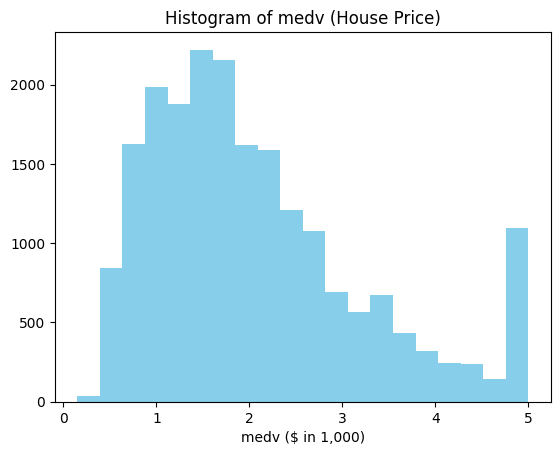

In [2]:
### Objective
# Explore SHAP values for an XGBoost model predicting 'medv' (housing price).

# Load Dataset
from sklearn.datasets import fetch_california_housing

data = fetch_california_housing()
df = pd.DataFrame(data.data, columns=data.feature_names)
df['medv'] = data.target  # medv as target variable

# Show first few rows
print("Dataset Overview:")
df.head()

# Plot the histogram of the target variable (medv)
plt.hist(df['medv'], bins=20, color='skyblue')
plt.title('Histogram of medv (House Price)')
plt.xlabel('medv ($ in 1,000)')
plt.show()

### Build a Model and Predict medv

We won't cover building a model in this article. I used XGBoost model.

In [3]:
### Split Data into Training and Testing Sets
X = df.drop('medv', axis=1)
y = df['medv']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [4]:
### Build and Train XGBoost Model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=200, random_state=42)
xgb_model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [5]:
# Predict on test data
y_pred = xgb_model.predict(X_test)

# Calculate RMSE and R^2
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
test_r2 = r2_score(y_test, y_pred)
print(f"Test RMSE: {test_rmse:.2f}")
print(f"Test R^2: {test_r2:.2f}")

Test RMSE: 0.47
Test R^2: 0.83


### Interpre SHAP  
Use the function *Explainer* to create an explainer object that helps us to interpret the model.

In [6]:
### Explain Model Predictions Using SHAP
# Set seed
random.seed(1)
# Create SHAP Explainer
explainer = dx.Explainer(xgb_model, X_test, y_test)
shap_values = explainer.predict_parts(X_test.iloc[1], type='shap', B=20, random_state=42)

Preparation of a new explainer is initiated

  -> data              : 4128 rows 8 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 4128 values
  -> model_class       : xgboost.sklearn.XGBRegressor (default)
  -> label             : Not specified, model's class short name will be used. (default)
  -> predict function  : <function yhat_default at 0x7fb04ba01fc0> will be used (default)
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 0.186, mean = 2.06, max = 5.56
  -> model type        : regression will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -3.21, mean = -0.0065, max = 3.16
  -> model_info        : package xgboost

A new explainer has been created!


## Use *predict_parts* function to get SHAP plot.  

- *new_observation*: Set a observation which you want to calculate SHAP (In this case 1)  
- *type*: Set the method  
- *B*: Number of trials of picking ways of "Participation Order"   

In this plot, we are extracting 1st observation of our test set. Whose explanatory variables and predictor variable are below.  

In [7]:
X_test.iloc[1]

,3024
MedInc,2.531300
HouseAge,30.000000
AveRooms,5.039384
AveBedrms,1.193493
Population,1565.000000
AveOccup,2.679795
Latitude,35.140000
Longitude,-119.460000



By looking at the plot, we can tell that *lstat* has the highest contribution to the prediction. To interpret, *lstat* contributes *medv* to be high for the positive direction, and next contributor is *rm*.

In [8]:
shap_values.plot()

### Gloval Feature Importance  

So far, we have discussed instance-level exploration. Now, let’s briefly touch on dataset-level exploration. While we won’t go into detail on this page, the core idea involves global-level explanatory variable analysis. Some methods, such as running SHAP for the entire dataset, can achieve this, but they are computationally expensive and time-consuming.

The key concept is to assess how a model’s performance changes when the influence of a specific explanatory variable, or a group of variables, is removed. This removal is achieved through perturbations, such as resampling from the empirical distribution or permuting the variable’s values.

In [9]:
### Explain Model Predictions Using SHAP
# Create SHAP Explainer
explainer = dx.Explainer(xgb_model, X_test, y_test)
exp_xg = explainer.model_parts(random_state=42)

Preparation of a new explainer is initiated

  -> data              : 4128 rows 8 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 4128 values
  -> model_class       : xgboost.sklearn.XGBRegressor (default)
  -> label             : Not specified, model's class short name will be used. (default)
  -> predict function  : <function yhat_default at 0x7fb04ba01fc0> will be used (default)
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 0.186, mean = 2.06, max = 5.56
  -> model type        : regression will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -3.21, mean = -0.0065, max = 3.16
  -> model_info        : package xgboost

A new explainer has been created!


In [10]:
exp_xg.plot()

Just like that one observation, *lstat* and *rm* are most important feature in the whole dataset.  

# Conclution  

SHAP is a sufficient method to observe variable importance on each observation. At the same time, SHAP also can be helpful to get overview of the whole model. However, SHAP cannot explain the relation ship between explanatory variable and responce variable, which can be explain with <a href = "https://qiita.com/shuseiyokoi/items/f6320d8612de42119d6e">ICE</a>.    